## Install dependencies

Install Hugging Face Diffusers (for Stable Diffusion), Transformers, Accelerate, and some performance helpers.

In [ ]:
# Create log directories
!mkdir -p /kaggle/working/logs
!touch /kaggle/working/logs/pip_install.log
!touch /kaggle/working/logs/train.log

In [ ]:
# 0. Clean cache (avoid stale wheels)
!pip cache purge

# 1. Uninstall ALL conflicting libs
!pip uninstall -y torch torchvision torchaudio diffusers transformers accelerate timm safetensors huggingface-hub

# 2. Install PyTorch + Torchvision (CUDA 12.1 build, stable for Kaggle)
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121

# 3. Install stable Hugging Face ecosystem
!pip install diffusers==0.30.0
!pip install transformers==4.44.2
!pip install accelerate==0.34.2
!pip install huggingface-hub==0.25.2
!pip install safetensors==0.4.5
!pip install peft==0.17.0
!pip install timm==1.0.7 bitsandbytes==0.44.1

# 4. Numpy fix (binary compatibility)
!pip install --upgrade --force-reinstall numpy==1.26.4


___

## Restart here

___

In [1]:
# 1. Remove old installs
!pip uninstall -y diffusers

# 2. Install the latest dev version from source (GitHub)
!pip install git+https://github.com/huggingface/diffusers.git

Found existing installation: diffusers 0.30.0
Uninstalling diffusers-0.30.0:
  Successfully uninstalled diffusers-0.30.0
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-d9hpc2qz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-d9hpc2qz
  Resolved https://github.com/huggingface/diffusers.git to commit fc337d585309c4b032e8d0180bea683007219df1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-py3-none-any.whl size=4177812 sha256=918d3e2d236817a351ddacc3d50385c2683e184f751c12b4ef4d481cbdb853db
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fmpaf1q/wheels/d2/5c/5f/16639722ea17ecb73ab461b81718584bac08af2801619786b9

In [2]:
# 2. Install the latest dev version from source (GitHub)
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers/examples/dreambooth

Cloning into 'diffusers'...
remote: Enumerating objects: 103657, done.
remote: Counting objects: 100% (1040/1040), done.
remote: Compressing objects: 100% (551/551), done.
remote: Total 103657 (delta 869), reused 490 (delta 488), pack-reused 102617 (from 4)
Receiving objects: 100% (103657/103657), 78.14 MiB | 28.94 MiB/s, done.
Resolving deltas: 100% (76413/76413), done.
/kaggle/working/diffusers/examples/dreambooth


In [3]:
import accelerate, diffusers, transformers

print("Accelerate:", accelerate.__version__)
print("Diffusers:", diffusers.__version__)
print("Transformers:", transformers.__version__)

Accelerate: 0.34.2
Diffusers: 0.36.0.dev0
Transformers: 4.44.2


In [4]:
print("done")

done


In [5]:
import os
os.environ["DIFFUSERS_IGNORE_FLAX"] = "1"

import torch
from diffusers import StableDiffusionPipeline

print(torch.__version__)
print("✅ diffusers work")


2025-09-06 09:59:42.107149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757152782.488950     161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757152782.597207     161 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


2.4.1+cu121
✅ diffusers work


In [6]:
# List installed packages
!pip list | grep -E "bitsandbytes|torch|diffusers|transformers|accelerate|numpy|scipy|scikit-learn|google-api-core|google-cloud-bigquery|google-cloud-storage|pandas|requests|tornado|notebook|google-auth|packaging|rich|filelock|cryptography|pyopenssl|matplotlib|toolz|typing-extensions|fsspec|google-cloud-bigquery-storage|huggingface-hub|peft|flax|jax|jaxlib|ml-dtypes"


accelerate                            0.34.2
bitsandbytes                          0.44.1
cryptography                          44.0.3
cytoolz                               1.0.1
diffusers                             0.36.0.dev0
filelock                              3.18.0
flax                                  0.10.6
fsspec                                2025.5.1
geopandas                             0.14.4
google-api-core                       1.34.1
google-auth                           2.40.3
google-auth-httplib2                  0.2.0
google-auth-oauthlib                  1.2.2
google-cloud-bigquery                 3.25.0
google-cloud-bigquery-connection      1.18.3
google-cloud-storage                  2.19.0
huggingface-hub                       0.34.4
jax                                   0.5.2
jax-cuda12-pjrt                       0.5.1
jax-cuda12-plugin                     0.5.1
jaxlib                                0.5.1
matplotlib                            3.7.2
matplotlib-

In [7]:
print("Libraries installed.")

Libraries installed.


## Configuration

Set paths, base model, LoRA hyperparameters.

In [8]:
import os, sys, glob, random, shutil, gc, math, time
from pathlib import Path

#### Paths

In [ ]:
# DATA_DIR = "/kaggle/input/animefacedataset/images"  
# WORK_IMAGES = "/kaggle/working/train_images"        
# OUTPUT_DIR = "/kaggle/working/anime-lora"           # where LoRA weights/checkpoints will be saved

# Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

### For another Dataset

In [9]:
DATA_DIR = "/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean"  
WORK_IMAGES = "/kaggle/working/train_images"        
OUTPUT_DIR = "/kaggle/working/anime-lora"           # where LoRA weights/checkpoints will be saved

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

#### Base Model

In [10]:
BASE_MODEL = "runwayml/stable-diffusion-v1-5"

INSTANCE_PROMPT = "anime style illustration"

#### Hyper-parameters

In [11]:
IMAGE_RES        = 512
TRAIN_BATCH_SIZE = 1
GRAD_ACCUM       = 4
LEARNING_RATE    = 1e-4
MAX_TRAIN_STEPS  = 1200       # 800–2000 typical
CHECKPOINT_STEPS = 400
MIXED_PRECISION  = "fp16"     # fp16 on T4
SEED             = 42

print("Config set.")

Config set.


## Dataset Sanity Check

Find images in your dataset and show a small sample. 

Requires at least about 15 images to learn a style reasonably.

In [12]:
img_exts = (".jpg", ".jpeg", ".png", ".webp", ".bmp")
paths = sorted([str(p) for p in Path(DATA_DIR).rglob("*") if p.suffix.lower() in img_exts])

print(f"Found {len(paths)} images in {DATA_DIR}")
print("Sample:", paths[:5])

assert len(paths) >= 15, "Need at least ~15 images. Add more images or fix DATA_DIR."

Found 4152 images in /kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean
Sample: ['/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean/000b5943f3ef3b4fab65c73cbcaaae37838c6ecc.jpg', '/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean/00525a9d874bb5f6fc35292028d03fb7a82aa312.jpg', '/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean/0052eab36cbda3ea64a61acf8f8c7c35eeb5b27d.jpg', '/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultrac

## (Optional) Curate/Copy Working Subset

Reading from /kaggle/input is fine, but copying to /kaggle/working lets you subsample or clean.

Set LIMIT to a number to train faster.

In [ ]:
# Path(WORK_IMAGES).mkdir(parents=True, exist_ok=True)

# LIMIT = 300   # e.g., 300 to speed up training iterations
# select = paths if LIMIT is None else random.sample(paths, min(LIMIT, len(paths)))

# # Copy only if not already present
# if not any(Path(WORK_IMAGES).iterdir()):
#     for p in select:
#         shutil.copy(p, Path(WORK_IMAGES) / Path(p).name)

# print("Working set size:", len(list(Path(WORK_IMAGES).glob('*') ) ) )

## Get official DreamBooth-LoRA training script

Clones the diffusers examples so we can use train_dreambooth_lora.py

**might edit**

In [ ]:
import os
os.environ["DIFFUSERS_IGNORE_FLAX"] = "1"

import torch
from diffusers import StableDiffusionPipeline

print(torch.__version__)
print("✅ diffusers work")

In [ ]:
# !pip install peft==0.17.0

In [ ]:
# !pip install bitsandbytes

In [ ]:
import torch, torchvision
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

### Looking up the second dataset tags, as it contains (male and female pics)

In [13]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/kaggle/input/anime-bodies/characters_processed.csv")
print(df.shape)
print(df.columns)
df.head()


(131023, 9)
Index(['id', 'eye_color', 'hair_color', 'hair_length', 'age', 'sex', 'mimikko',
       'romji', 'image'],
      dtype='object')


,id,eye_color,hair_color,hair_length,age,sex,mimikko,romji,image
0,1,Green,Orange,To neck,Teen,Female,Human,Kazumi Himekawa,uploads/chars/4758-997489678.png
1,2,Purple,Purple,To Chest,Adult,Female,Human,Chihiro Midou,uploads/chars/4758-904869381.png
2,3,Brown,Blonde/Yellow,To neck,Teen,Female,Human,Misaki Tokiwa,uploads/chars/4758-2020536440.png
3,4,Blue,Blonde/Yellow,To Chest,Teen,Female,Human,Sana Horiuchi,uploads/chars/4758-253813792.png
4,5,Blue,Blue-Green,Past Waist,Teen,Female,Human,Fumika Riku,uploads/chars/4758-910775020.png


In [14]:
import os
import pandas as pd

# Load the CSV
csv_path = "/kaggle/input/anime-bodies/characters_processed.csv"
df = pd.read_csv(csv_path)

# Path to images folder
image_dir = "/kaggle/input/anime-bodies/images"

# Count and preview images in the folder
all_images = os.listdir(image_dir)
print("Total images in folder:", len(all_images))
print("First 10 images in folder:", all_images[:10])

# Preview 'image' column from CSV
print("\nFirst 10 entries from CSV 'image' column:")
print(df['image'].head(10))

# Preview id column too (to check mapping)
print("\nFirst 10 IDs from CSV 'id' column:")
print(df['id'].head(10))


Total images in folder: 131023
First 10 images in folder: ['64284.png', '99807.jpg', '30778.jpg', '91989.png', '19812.jpg', '38246.jpg', '16916.jpg', '52876.jpg', '36145.png', '105850.png']

First 10 entries from CSV 'image' column:
0     uploads/chars/4758-997489678.png
1     uploads/chars/4758-904869381.png
2    uploads/chars/4758-2020536440.png
3     uploads/chars/4758-253813792.png
4     uploads/chars/4758-910775020.png
5     uploads/chars/4758-857796738.png
6      uploads/chars/4758-93275064.png
7     uploads/chars/4758-124664202.png
8    uploads/chars/67712-693039845.png
9     uploads/chars/4758-386433225.png
Name: image, dtype: object

First 10 IDs from CSV 'id' column:
0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: id, dtype: int64


In [15]:
# Check dataset sizes
print("CSV rows:", len(df))
print("Image files:", len(all_images))

# Sort image filenames numerically (strip extensions first)
import re
def num_from_name(fname):
    return int(re.sub(r"\D", "", fname))  # keep only digits

sorted_imgs = sorted(all_images, key=num_from_name)

print("\nFirst 5 sorted image files:", sorted_imgs[:5])
print("First 5 CSV ids:", df['id'].head().tolist())
print("Last 5 sorted image files:", sorted_imgs[-5:])
print("Last 5 CSV ids:", df['id'].tail().tolist())

## the id corresponds to the image name

CSV rows: 131023
Image files: 131023

First 5 sorted image files: ['1.png', '2.png', '3.png', '4.png', '5.png']
First 5 CSV ids: [1, 2, 3, 4, 5]
Last 5 sorted image files: ['131025.png', '131026.png', '131027.png', '131028.png', '131029.png']
Last 5 CSV ids: [131025, 131026, 131027, 131028, 131029]


#### Copying the female pics with the tag female in 'sex' column (not gifs) to female_images_only file I made in kaggle/working

In [ ]:
# import pandas as pd
# import os, shutil

# # Load metadata
# df = pd.read_csv("/kaggle/input/anime-bodies/characters_processed.csv")

# # Filter for female rows
# female_df = df[df['sex'].str.lower() == 'female']
# print("Total female characters:", len(female_df))

# # Directories
# image_dir = "/kaggle/input/anime-bodies/images"
# dst_dir = "/kaggle/working/female_images_only"
# os.makedirs(dst_dir, exist_ok=True)

# # Copy female images (skip GIFs)
# copied = 0
# for _, row in female_df.iterrows():
#     img_id = row['id']
    
#     # Possible extensions
#     for ext in [".png", ".jpg", ".jpeg"]:
#         src = os.path.join(image_dir, f"{img_id}{ext}")
#         if os.path.exists(src) and not src.lower().endswith(".gif"):
#             shutil.copy(src, os.path.join(dst_dir, f"{img_id}{ext}"))
#             copied += 1
#             break  # stop after first valid match

# print(f"Copied {copied} female images (excluding GIFs) into {dst_dir}")

### Copy and resize (anime-bodies) dataset in 1 method instead of copying and pasting twice (didn't try it yet)

In [16]:
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm

# Parameters
max_images = 30000  # change this number to control how many images you want
csv_path = "/kaggle/input/anime-bodies/characters_processed.csv"
image_dir = "/kaggle/input/anime-bodies/images"
dst_dir = "/kaggle/working/resized_dataset"

# Load metadata
df = pd.read_csv(csv_path)

# Filter female rows and take only max_images
female_df = df[df['sex'].str.lower() == 'female'].head(max_images)
print("Total female characters available:", len(df[df['sex'].str.lower() == 'female']))
print(f"Processing {len(female_df)} images...")

# Ensure destination exists
os.makedirs(dst_dir, exist_ok=True)

# Process images
count = 0
for _, row in tqdm(female_df.iterrows(), total=len(female_df), desc="Resizing & saving"):
    img_id = row['id']
    
    # Try possible extensions
    for ext in [".png", ".jpg", ".jpeg"]:
        src = os.path.join(image_dir, f"{img_id}{ext}")
        if os.path.exists(src) and not src.lower().endswith(".gif"):
            try:
                with Image.open(src) as img:
                    img = img.convert("RGB")  # ensure 3 channels
                    img = img.resize((512, 512), Image.BICUBIC)
                    dst_path = os.path.join(dst_dir, f"{img_id}.png")  # save unified as PNG
                    img.save(dst_path, format="PNG")
                    count += 1
            except Exception as e:
                print(f"Skipping {src}: {e}")
            break  # stop after finding the first valid extension

print(f"\n✅ Resized and saved {count} female images into {dst_dir}")


Total female characters available: 75500
Processing 30000 images...


Resizing & saving:  26%|██▌       | 7748/30000 [09:19<14:55, 24.86it/s]  /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Resizing & saving:  38%|███▊      | 11264/30000 [13:24<28:02, 11.13it/s]

Skipping /kaggle/input/anime-bodies/images/15515.jpg: image file is truncated (5 bytes not processed)


Resizing & saving:  82%|████████▏ | 24496/30000 [30:59<04:45, 19.29it/s]

Skipping /kaggle/input/anime-bodies/images/38218.jpg: image file is truncated (4 bytes not processed)
Skipping /kaggle/input/anime-bodies/images/38219.jpg: image file is truncated (0 bytes not processed)


Resizing & saving: 100%|██████████| 30000/30000 [38:26<00:00, 13.00it/s]


✅ Resized and saved 28403 female images into /kaggle/working/resized_dataset


### Optionally resize images beforehand to avoid huge ones (take more time in training)

**your modified training dataset will be in /kaggle/working/ not input**

### Copying anime-bodies

In [ ]:
# import os
# from PIL import Image
# from tqdm import tqdm

# # Paths
# src_dir = "/kaggle/working/female_images_only"
# dst_dir = "/kaggle/working/resized_dataset"
# os.makedirs(dst_dir, exist_ok=True)

# # 🔹 Change this number to control how many images you want
# max_images = 20000  

# # Collect images (sorted for consistency)
# all_images = sorted(os.listdir(src_dir))
# selected_images = all_images[:max_images]

# count = 0
# for fname in tqdm(selected_images, desc=f"Resizing & moving up to {max_images} images"):
#     src_path = os.path.join(src_dir, fname)
#     dst_path = os.path.join(dst_dir, fname)

#     try:
#         with Image.open(src_path) as img:
#             img = img.convert("RGB")  # ensure 3 channels
#             img = img.resize((512, 512), Image.BICUBIC)
#             img.save(dst_path, format="PNG")
#             count += 1
#         # Delete original after successful save
#         os.remove(src_path)
#     except Exception as e:
#         print(f"Skipping {fname}: {e}")

# print(f"\n✅ Resized {count} images into {dst_dir} and deleted originals from {src_dir}")

### Copying fullbody-anime-girls-dataset

In [ ]:
import os, shutil
from PIL import Image

# Paths
src_dir = "/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean"
dst_dir = "/kaggle/working/resized_dataset"

# Copy dataset to working dir
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

# Mapping extensions to Pillow formats
ext_to_format = {
    "jpg": "JPEG",
    "jpeg": "JPEG",
    "png": "PNG"
}

# Resize images safely to 512x512 while keeping format
for file in os.listdir(dst_dir):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(dst_dir, file)
        img = Image.open(path).convert("RGB").resize((512, 512))  # force 512x512
        ext = os.path.splitext(file)[1].lower().replace(".", "")  # get extension without dot
        fmt = ext_to_format.get(ext, "PNG")  # default to PNG if unknown
        img.save(path, fmt)


print("✅ Done copying and resizing")

### I did this one just cleared the ouput cell by mistake

##### If you want all pics to change to .jpeg

In [ ]:
# import os, shutil
# from PIL import Image

# # Paths
# src_dir = "/kaggle/input/fullbody-anime-girls-datasets/ganime_fullbody_ultraclean_256/resized_ganime_fullbody_ultraclean-20220708T155251Z-002/resized_ganime_fullbody_ultraclean"
# dst_dir = "/kaggle/working/resized_dataset"

# # Copy dataset to working dir
# shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

# # Resize images safely to 512x512
# for file in os.listdir(dst_dir):
#     if file.lower().endswith((".jpg", ".jpeg", ".png")):
#         path = os.path.join(dst_dir, file)
#         img = Image.open(path)
#         img = img.convert("RGB").resize((512, 512))  # force 512x512
#         img.save(path, "JPEG")


## Launch Training (Accelerate)

Trains LoRA adapters on the anime faces dataset

In [ ]:
# /kaggle/working/diffusers/examples/dreambooth/diffusers/examples/dreambooth/train_dreambooth_lora.py

In [ ]:
# !accelerate launch /kaggle/working/diffusers/examples/dreambooth/train_dreambooth_lora.py \
#   --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
#   --instance_data_dir="/kaggle/input/animefacedataset/images" \
#   --output_dir="/kaggle/working/anime-lora" \
#   --instance_prompt="anime face" \
#   --resolution=512 \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=4 \
#   --learning_rate=1e-4 \
#   --lr_scheduler="constant" \
#   --max_train_steps=1200 \
#   --seed=42 \
#   --checkpointing_steps=400 \
#   --mixed_precision="fp16" \
#   --use_8bit_adam \
#   --validation_prompt="anime face" \
#   --num_validation_images=4 \
#   --validation_epochs=50

In [ ]:
dst_dir = "/kaggle/working/female_images_only"
files = os.listdir(dst_dir)

print("Total images in resized_dataset:", len(files))

In [18]:
dst_dir = "/kaggle/working/resized_dataset"
files = os.listdir(dst_dir)

print("Total images in resized_dataset:", len(files))

Total images in resized_dataset: 32555


In [20]:
!accelerate launch /kaggle/working/diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --instance_data_dir="/kaggle/working/resized_dataset" \
  --output_dir="/kaggle/working/anime-lora" \
  --instance_prompt="1 girl, anime style, full body" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=2e-5 \
  --lr_scheduler="constant" \
  --max_train_steps=5000 \
  --seed=42 \
  # --checkpointing_steps=400 \
  --mixed_precision="no" \
  --validation_prompt="anime girl,full body, masterpiece, best quality, high details, no deformations" \
  --num_validation_images=4 \
  --validation_epochs=5 \
  --max_grad_norm=0

2025-09-06 11:24:45.659749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-06 11:24:45.659749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757157885.684683     286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757157885.684689     287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757157885.691856     287 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1757157885.691904     286 cuda_blas.cc:1

--instance_prompt="anime girl full body" \

--validation_prompt="anime girl, full body, masterpiece, best quality, high details, no deformations" \

**--mixed_precision="fp16" \ (older parameter)**

**--mixed_precision="bf16" \  # more stable  (takes waaaaaaaay longer time)**

**--mixed_precision="no" \ more stable (takes longer time but not as "bf16"**

**--use_8bit_adam** for lower memory usage. (sometimes cause error) (I removed it)

#### Improving Image Quality

To get better, cleaner anime girl images (full body, high quality), you can tune these:

✅ Training Parameters

--train_batch_size=1 → You can keep this (Kaggle memory limits), but if VRAM allows, increase to 2.

--learning_rate=1e-4 → Sometimes too high for LoRA. Try 5e-5 or 2e-5 for more stable training.

--resolution=512 → Good, but if your dataset supports it, you can go to 768 for higher detail.

--max_train_steps=2000 → If results look undertrained, increase to 4000–6000.

✅ Validation & Checkpoints

--validation_epochs=50 → Too high (rare validation). Change to --validation_epochs=5 so you see progress more often.

--checkpointing_steps=400 → Keep or reduce to 200 if you want more frequent checkpoints.

## Inference with your trained LoRA

Load SD 1.5 and attach your trained LoRA adapters. Generates a sample image.

In [21]:
import os
print(os.listdir("/kaggle/working/anime-lora"))

['checkpoint-1500', 'logs', 'checkpoint-4500', 'checkpoint-5000', 'checkpoint-500', 'checkpoint-3000', 'checkpoint-2500', 'checkpoint-3500', 'checkpoint-2000', 'checkpoint-1000', 'checkpoint-4000', 'pytorch_lora_weights.safetensors']


In [ ]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, DDIMScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
from peft import PeftModel
import torch

In [44]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA weights
lora_dir = "/kaggle/working/anime-lora/pytorch_lora_weights.safetensors"
# pipe.unet.load_attn_procs(lora_dir)      # this is what I used before, but the dir was /kaggle/working/anime-lora/
# pipe.unet = peftModel.form_pretrained(pipe.unet, OUTPUT_DIR)

# Load LoRA into pipeline (optional step)
pipe.load_lora_weights(lora_dir)

# Apply LoRA with a strength (scale factor)
pipe.fuse_lora(lora_scale=0.9)          # 0.6–1.0 usually works best

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


0.6–0.8 → subtle influence.

1.0–1.2 → strong style influence (may override prompt).

higher than 1.3 → usually causes distortions.

In [ ]:
# from diffusers import StableDiffusionPipeline
# from peft import PeftModel
# import torch

# # Load base model
# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     torch_dtype=torch.float16
# )

# # Load LoRA weights
# pipe.unet = PeftModel.from_pretrained(pipe.unet, OUTPUT_DIR)

# # # Use the model
# # if torch.cuda.is_available():
# #     pipe = pipe.to("cuda")

# # image = pipe("beautiful cloth design").images[0]
# # image.save("generated.png")

In [ ]:
# import torch
# from diffusers import StableDiffusionPipeline

# BASE_MODEL = "runwayml/stable-diffusion-v1-5"
# lora_dir = "/kaggle/working/anime-lora"

# # Load the base model
# pipe = StableDiffusionPipeline.from_pretrained(
#     BASE_MODEL,
#     torch_dtype=torch.float16
# ).to("cuda")

# # Load the LoRA weights (new API)
# pipe.load_lora_weights(lora_dir)

# # If you want to *merge* LoRA into UNet weights permanently:
# pipe.fuse_lora()

  0%|          | 0/30 [00:00<?, ?it/s]

Image saved to: /kaggle/working/anime-lora/sample_output.png


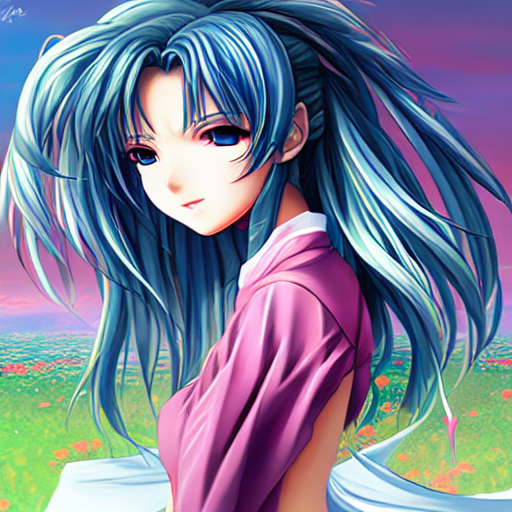

In [24]:
# Generate a test image (without lora [didn't use lora right so it only used SD 1.5])
prompt = "1girl, detailed eyes, vibrant lighting, anime style, ultra-detailed background, Fullbody, from head to feet, masterpiece"
negative_prompt = "blurry, low quality, deformed, extra limbs, text, watermark, extra fingers"

with torch.autocast("cuda", dtype=torch.float16):  # // Loads the model weights in half precision (FP16) instead of the default 32-bit floats. (saves GPU memory, Slightly faster on modern GPUs, Needs a GPU that supports FP16 (almost all newer NVIDIA ones do))
    image = pipe(
        prompt, 
        negative_prompt=negative_prompt, 
        num_inference_steps=30,
        guidance_scale=7.5, 
        height=IMAGE_RES, 
        width=IMAGE_RES,
        generator=torch.Generator(device="cuda").manual_seed(1234)
    ).images[0]

# Save the generated image
save_path = "/kaggle/working/anime-lora/sample_output.png"
image.save(save_path)
print(f"Image saved to: {save_path}")

# Display the image (if in Jupyter)
from IPython.display import Image, display
display(Image(save_path))

  0%|          | 0/30 [00:00<?, ?it/s]

Image saved to: /kaggle/working/anime-lora/sample_output.png


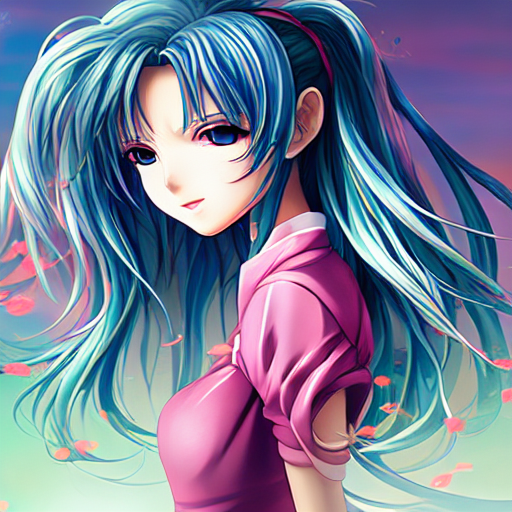

In [45]:
# Generate a test image (with lora)
prompt = "1girl, detailed eyes, vibrant lighting, anime style, ultra-detailed background, Fullbody, from head to feet, masterpiece"
negative_prompt = "blurry, low quality, deformed, extra limbs, text, watermark, extra fingers"

with torch.autocast("cuda", dtype=torch.float16):  # // Loads the model weights in half precision (FP16) instead of the default 32-bit floats. (saves GPU memory, Slightly faster on modern GPUs, Needs a GPU that supports FP16 (almost all newer NVIDIA ones do))
    image = pipe(
        prompt, 
        negative_prompt=negative_prompt, 
        num_inference_steps=30,
        guidance_scale=7.5, 
        height=IMAGE_RES, 
        width=IMAGE_RES,
        generator=torch.Generator(device="cuda").manual_seed(1234)
    ).images[0]

# Save the generated image
save_path = "/kaggle/working/anime-lora/sample_output.png"
image.save(save_path)
print(f"Image saved to: {save_path}")

# Display the image (if in Jupyter)
from IPython.display import Image, display
display(Image(save_path))

#### Schedulers (you can select different ones to try some make the result faster but worse and vice versa)

In [46]:
from diffusers import EulerAncestralDiscreteScheduler, DDIMScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler

In [93]:
## Euler Ancestral (sharp, great for anime/art)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

## DDIM (smooth, softer outputs)
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

## DPM++ 2M (very high quality, balanced)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

## LMS (good for general-purpose)
# pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)


## EulerAncestral or DPM++ are usually the best.

Using seed: 3526296294


  0%|          | 0/300 [00:00<?, ?it/s]

Image saved to: /kaggle/working/anime-lora/sample_output.png


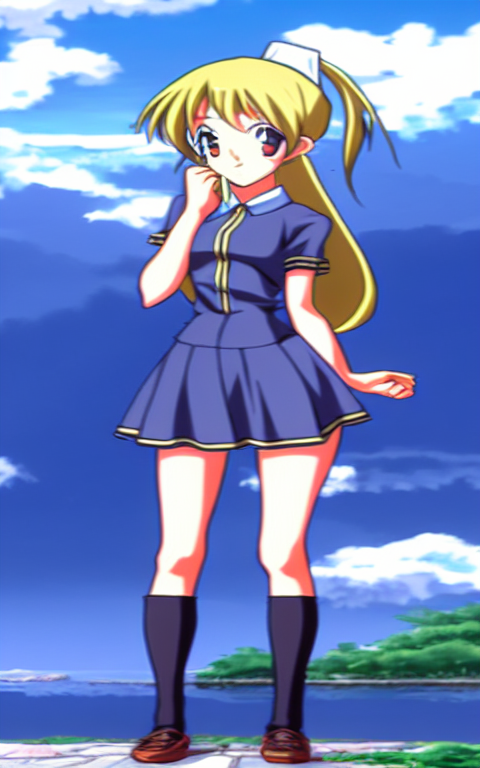

In [107]:
# Generate a test image

# same prompts above
og_prompt = "one girl, detailed eyes, vibrant lighting, anime style, ultra-detailed background, Fullbody, from head to feet, masterpiece"
og_negative_prompt = "blurry, low quality, deformed, extra limbs, text, watermark, extra fingers"


prompt = "one girl only, full body, standing, from head to toe, front facing, whole figure, centered, anime girl, masterpiece, clear background, background has one color, clear mouth, mouth not open, five fingers, clear eyes, two legs, two hands, legs have the same color, clear and high quality face"
negative_prompt = "random dots in the face, cropped, portrait, close-up, bust shot, zoomed-in, blurry, low quality, deformed, extra limbs, text, watermark, extra fingers, extra legs, NSFW, background with different colors, less than five fingers"

# to Generate a random pic, and knowing the seed
import random

seed = random.randint(0, 2**32 - 1)
print("Using seed:", seed)


with torch.autocast("cuda"):  # , dtype=torch.float16 # // Loads the model weights in half precision (FP16) instead of the default 32-bit floats. (saves GPU memory, Slightly faster on modern GPUs, Needs a GPU that supports FP16 (almost all newer NVIDIA ones do))
    image = pipe(
        prompt, 
        negative_prompt=negative_prompt,
        height=768,    # 768    (560 = 8 * 70)
        width=480,     # 512    (384 = 8 * 48)        `height` and `width` have to be divisible by 8
        num_inference_steps=300,
        guidance_scale=12,   # 7.5 is recommended
        generator=torch.Generator(device="cuda").manual_seed(seed)
    ).images[0]

# Save the generated image
save_path = "/kaggle/working/anime-lora/sample_output.png"
image.save(save_path)
print(f"Image saved to: {save_path}")

# Display the image (if in Jupyter)
from IPython.display import Image, display
display(Image(save_path))

### parameters:

1. **Number of Inference Steps (num_inference_steps)**

>Controls how many denoising steps the diffusion model takes.

>Higher steps = more refined details, but slower.

>Too many steps can cause over-smoothing or wasted compute.

>Typical ranges:

>20–30: Fast, decent quality.

>30–50: High quality, more details.

>more than 75: Rarely improves results much.

2. **Seed (generator or seed)**

>Controls randomness in sampling.

>Same prompt + same seed → reproducible result.

>Different seeds → different variations.

>Useful for prompt experimentation.

3. **Scheduler**

>The sampling algorithm that controls how noise is reduced each step.

>Common ones:

> * DDIM → Fast, smooth images, often softer.

> * Euler / Euler a → Sharper, good for anime/artwork.

> * DPM++ 2M / 2M Karras → Very good balance of speed + quality, often best for realism.

>Trying different schedulers can drastically change results.


4. **Image Dimensions (height, width)**

>Larger = more detail, but more VRAM/compute.

>Common for SD:

>512×512 (SD1.5 default)

>768×768 (SDXL default)

>Wide/tall ratios can help match certain prompts (e.g., landscape, portrait).

5. **Guidance Scale**

>Typical Range

>1.0 → No guidance (model ignores prompt, pure unconditional generation).

>3 – 7 → Balanced zone (often the sweet spot).

>7 – 12 → Strong adherence to prompt (but risk of artifacts, less diversity).

>More than 15 → Usually too strong, outputs can break down or look unnatural.

**with torch.autocast("cuda", dtype=torch.float16):**

Tells PyTorch:

“When running on the GPU, use FP16 where possible to save memory and run faster.”

This is useful because image generation is heavy on VRAM, and FP16 almost halves the memory usage.

**image = pipe(...).images[0]**

This calls the Stable Diffusion pipeline to actually generate an image.

the arguments:

prompt → Your text prompt describing what you want.

negative_prompt → Words describing what you don’t want in the image (e.g., “blurry, bad anatomy”).

num_inference_steps=30 → Number of denoising steps (more steps → higher quality, slower).

guidance_scale=7.5 → How strongly the model should follow your prompt (higher = more prompt detail, but can overfit).

height / width = IMAGE_RES → Output resolution in pixels.

generator=torch.Generator(device="cuda").manual_seed(1234) → Sets a random seed for reproducibility (same seed + same prompt = same image).

.images[0] → The pipeline can return multiple images, but here we take only the first one.

## Download the reulting Image via a link

In [ ]:
# Check if your specific file exists
your_filename = "/kaggle/working/anime-lora/sample_output.png"  # Replace with actual filename
filepath = f"{your_filename}"
print(f"\nFile exists: {os.path.exists(filepath)}")
if os.path.exists(filepath):
    print(f"File size: {os.path.getsize(filepath)} bytes")

In [ ]:
from IPython.display import Image, display, HTML
import base64
import os

filepath = "/kaggle/working/anime-lora/sample_output.png"

print("🖼️ Your anime image is ready for download!")
print(f"File size: {os.path.getsize(filepath):,} bytes")

# Display the image for right-click download
print("\n📥 RIGHT-CLICK the image below and select 'Save image as...'")
display(Image(filepath, width=600))

# Create a download button as backup
with open(filepath, 'rb') as f:
    img_data = base64.b64encode(f.read()).decode()

html = f'''
<div style="margin: 20px 0; padding: 20px; background: #f8f9fa; border: 2px solid #007cba; border-radius: 8px;">
    <h3 style="color: #007cba; margin-top: 0;">📥 Download Your Anime Image</h3>
    
    <div style="margin: 15px 0;">
        <strong>Method 1 (Recommended):</strong> Right-click the image above → "Save image as..."
    </div>
    
    <div style="margin: 15px 0;">
        <strong>Method 2:</strong> Click the button below:
        <br><br>
        <a href="data:image/png;base64,{img_data}" download="anime_sample_output.png" 
           style="text-decoration: none;">
            <button style="padding: 12px 24px; background: #28a745; color: white; border: none; 
                          border-radius: 6px; cursor: pointer; font-size: 16px; font-weight: bold;">
                💾 Download PNG Image
            </button>
        </a>
    </div>
    
    <div style="margin-top: 15px; font-size: 12px; color: #666;">
        File: sample_output.png | Size: {os.path.getsize(filepath):,} bytes
    </div>
</div>
'''

display(HTML(html))

#### Displaying some pics from the resized dataset

In [ ]:
display(Image("/kaggle/working/resized_dataset/000b5943f3ef3b4fab65c73cbcaaae37838c6ecc.jpg"))

In [ ]:
display(Image("/kaggle/working/resized_dataset/00525a9d874bb5f6fc35292028d03fb7a82aa312.jpg"))

## (Optional) Resume / use a specific checkpoint

Shows how to load a particular checkpoint folder (e.g., checkpoint-400).

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

ckpt_dir = f"{OUTPUT_DIR}/checkpoint-{CHECKPOINT_STEPS}"  # adjust number as needed

pipe = StableDiffusionPipeline.from_pretrained(BASE_MODEL, torch_dtype=torch.float16).to("cuda")
pipe.unet.load_attn_procs(ckpt_dir)

img = pipe("anime portrait, intricate details, best quality").images[0]

img.save("/kaggle/working/ckpt_sample.png")
"/kaggle/working/ckpt_sample.png"